<a href="https://colab.research.google.com/github/otvet4ikov/different_notebooks/blob/main/%D0%A2%D0%97_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B3%D0%BE%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импортируем необходимые библиотеки для анализа датасета

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


plt.style.use('ggplot')

Скачаем данные

In [ ]:
data = pd.read_csv("forFBpost.csv", delimiter=";")

Для начала нужно посмотреть, что за данные содержаться в датафрейме, их тип, количество и наличие пропусков

In [ ]:
data

In [ ]:
data.isna().sum()

Для каждого города по годам написаны численность населения фактическая и предсказанная моделью. Размер датафрема 30250х6. Количество пропусков 27000 в фактической численности населения, так как там года идут до 2120.

Переведем значения населения в тыс. это нужно для красивого отображения на графиках. Также переименуем столбцы в английский для удобства, так как вначале два столбца на английском, а четыре на русском.

In [ ]:
data = data.rename(columns={"Город": "City", 'Модель': 'Model', "Нижняя граница": "low", "Верхняя граница": 'high'})
data.Model = data.Model/1000
data.low = data.low/1000
data.high = data.high/1000
data.fact = data.fact/1000

Построим  распределение фактической численности населения по годам.

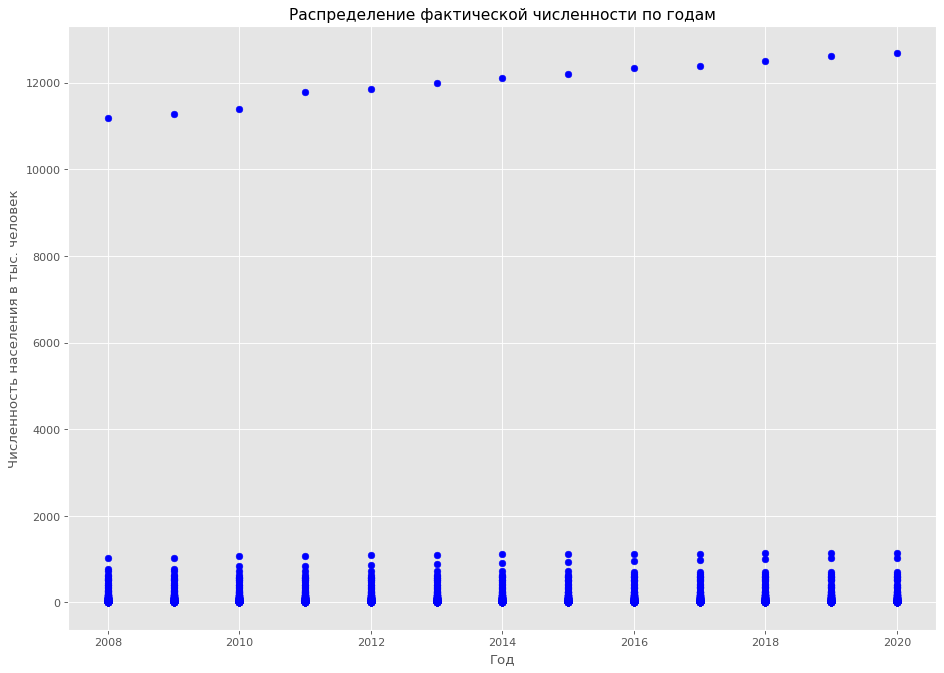

In [ ]:
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(x='year', y='fact', data=data, c='blue')
plt.xlabel('Год')
plt.ylabel('Численность населения в тыс. человек')
plt.title("Распределение фактической численности по годам", fontsize=14);


Как видим, один из городов значительно отличается от среднего населения в других городах. То есть для исследования он будет представлять выброс. Можно определить этот город, отранжировав города по численности населения.

In [ ]:
data.sort_values('fact', ascending=False).head()

,City,year,fact,Model,low,high
15750,Москва,2020,12678.079,12633.6,12597.2,12670.1
15749,Москва,2019,12615.279,12547.2,12510.0,12584.5
15748,Москва,2018,12506.468,12454.6,12416.6,12492.7
15747,Москва,2017,12380.664,12355.3,12316.6,12394.2
15746,Москва,2016,12330.126,12248.5,12209.0,12288.2


То есть выбросом в данном случае является город Москва.

In [ ]:
without_moscow = data[data['City'] != 'Москва']
without_moscow.shape

(30129, 6)

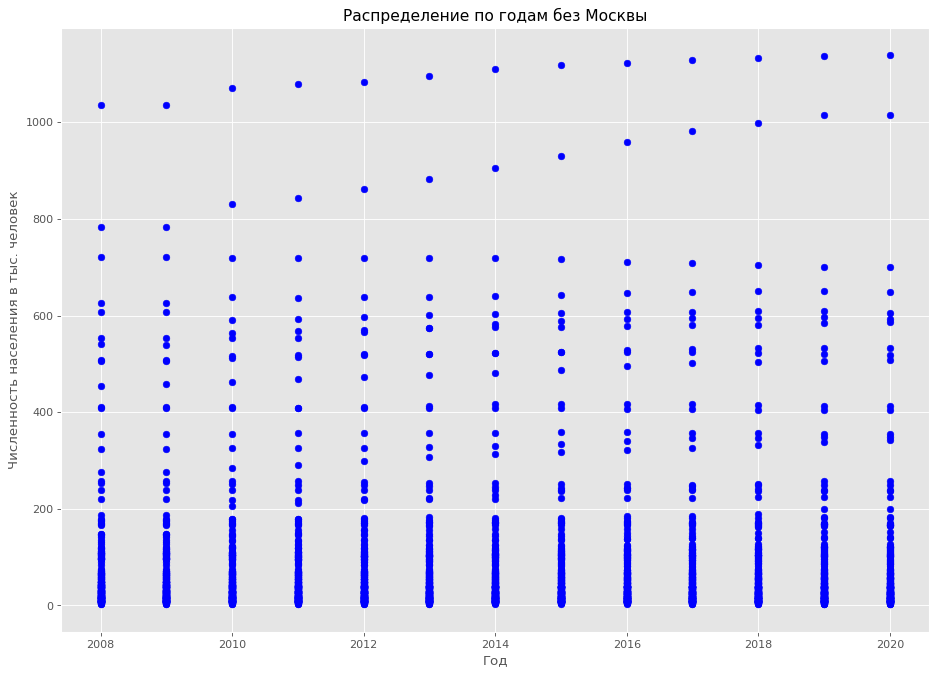

In [ ]:
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(x='year', y='fact', data=without_moscow, c='blue')
plt.xlabel('Год')
plt.ylabel('Численность населения в тыс. человек')
plt.title("Распределение по годам без Москвы", fontsize=14);

Как видим, теперь численность примерно одинакова. Построим изменение численности населения в зависимости от лет. Красным обозначена фактическая численность, а синим предсказанная.

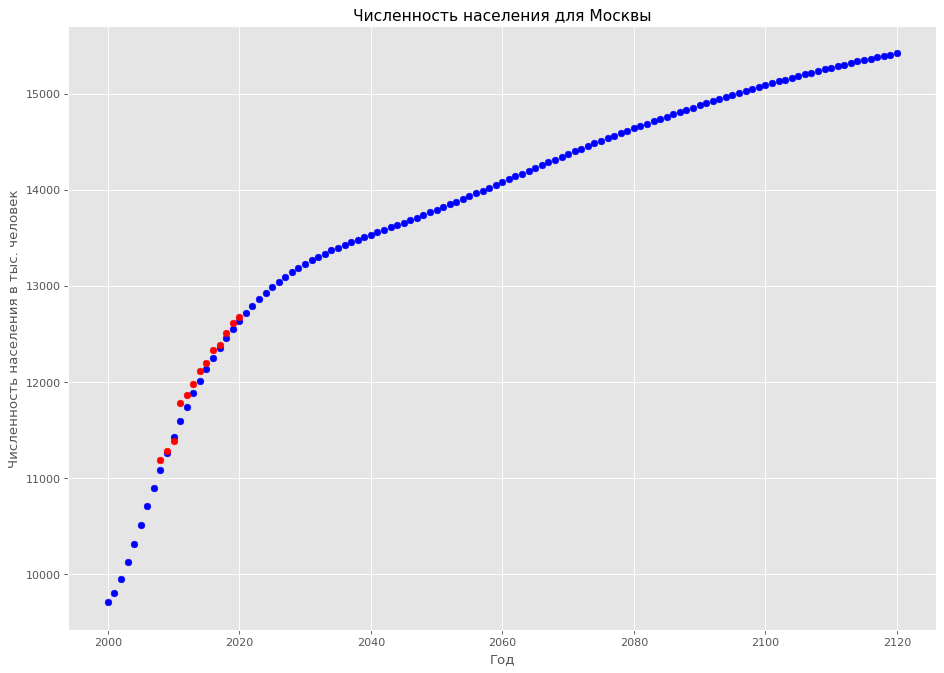

In [ ]:
moscow = data[data['City'] == 'Москва']
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel('Год')
plt.ylabel('Численность населения в тыс. человек')
plt.title("Численность населения для Москвы", fontsize=14);

plt.scatter(x='year', y='Model', data=moscow, c='blue')
plt.scatter(x='year', y='fact', data=moscow, c='red');

В целом, модель справляется в прогнозировании, но участок достаточно узкий, для точного ответа на вопрос. При этом  модель прогнозирует снижение роста населения со временем.

Выбросим все пустые значения и найдём процентное отношение прироста населения от года к году.

In [ ]:
dropped_data = data.dropna()
dropped_data.isna().sum()

City     0
year     0
fact     0
Model    0
low      0
high     0
dtype: int64

In [ ]:
percent = pd.DataFrame()

for city in dropped_data.City.unique():
  city_data = dropped_data[dropped_data.City == city]
  percent = pd.concat([percent, round(city_data.fact.pct_change(), 4)*100])
  # print(city_data.fact.pct_change())

percent = percent.rename(columns={0: 'percent'})


Построим распределения процентного прироста в виде гистограммы

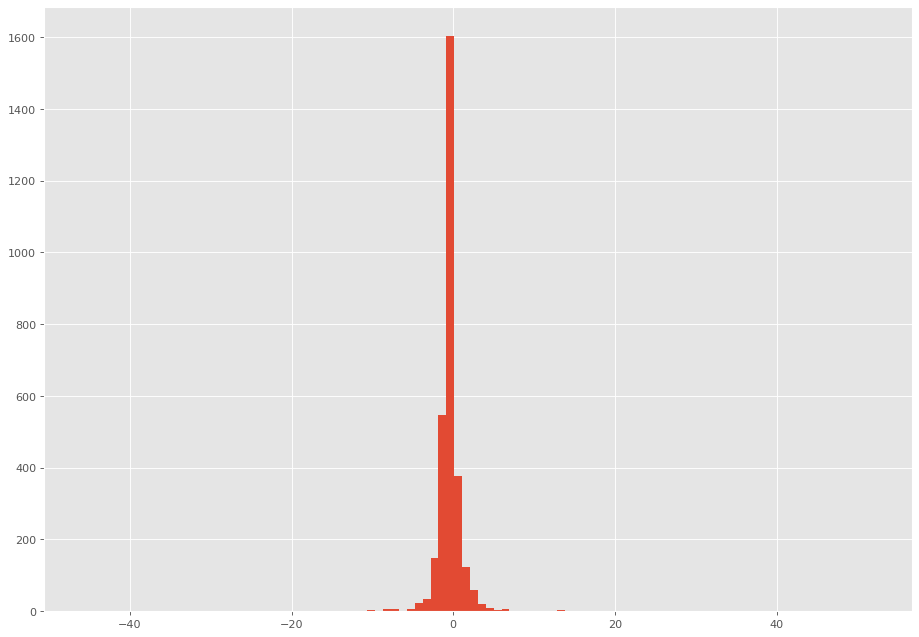

In [ ]:
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(percent['percent'], bins=100);

Как видим из графика, в основном прирост около нуля, но существуют выбросы, когда прирост больше 10, 20, 30 процентов. Максимальные выбросы 51.86% и -45.76%.

In [ ]:
percent.sort_values('percent', ascending=False)

,percent
7876,51.86
4490,39.87
29292,30.52
7755,30.21
28445,25.06
...,...
29653,NaN
29774,NaN
29895,NaN
30016,NaN


Аналогично сделаем для предсказания модели.

In [ ]:
percent_model = pd.DataFrame()

for city in data.City.unique():
  city_data = data[data.City == city]
  percent_model = pd.concat([percent_model, round(city_data.Model.pct_change(), 4)*100])
  # print(city_data.fact.pct_change())

percent_model = percent_model.rename(columns={0: 'percent'})




In [ ]:
percent_model.sort_values(by='percent', ascending=False)

,percent
29394,inf
7859,inf
29396,100.0
29398,50.0
28546,50.0
...,...
29645,NaN
29766,NaN
29887,NaN
30008,NaN


Возникли бесконечности из-за того, что в некоторых городах в одном году численность была равна 0, а затем увеличилась и прирост составляет бесконечное количество процентов. Выбросим эти значения как и значения 100 и -100. Для этого заменим их на NaN и выбросим.

Также изобразим гистограмму распределения численности

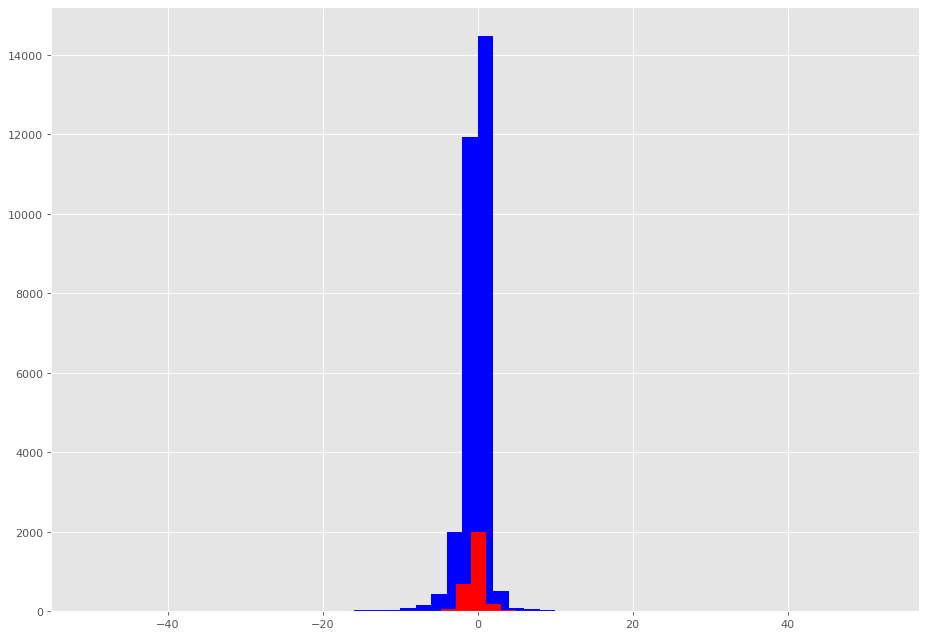

In [ ]:
percent_model.replace([np.inf, -np.inf, 100, -100], np.nan, inplace=True)
percent_model = percent_model.dropna()
percent = percent.dropna()

plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(percent_model['percent'], bins=50, color='blue')
plt.hist(percent['percent'], bins=50, color='red');

Как видим, и модельный и фактический прирост распределены около нуля по нормальному распределению. То есть численость во всех гоородах растет относительно одинаково от года к году.

Но лучше всего найти насколько возрастёт численность населения относительно начала отсчёта, так как инвестиции в эти города будут самыми прибыльными. Сделаем это на основе прдесказаний модели.

In [ ]:
grows_model = pd.DataFrame()

for city in data.City.unique():
  city_data = data[data.City == city]

  grow = city_data.Model/city_data.iloc[0].Model
  gr = pd.concat([city_data.City, city_data.year, grow], axis = 1)
  grows_model = pd.concat([grows_model, gr])
grows_model

,City,year,Model
0,Белокуриха,2000,1.000000
1,Белокуриха,2001,1.000000
2,Белокуриха,2002,1.000000
3,Белокуриха,2003,0.993506
4,Белокуриха,2004,0.993506
...,...,...,...
30245,Облучье,2116,0.044776
30246,Облучье,2117,0.044776
30247,Облучье,2118,0.044776
30248,Облучье,2119,0.044776


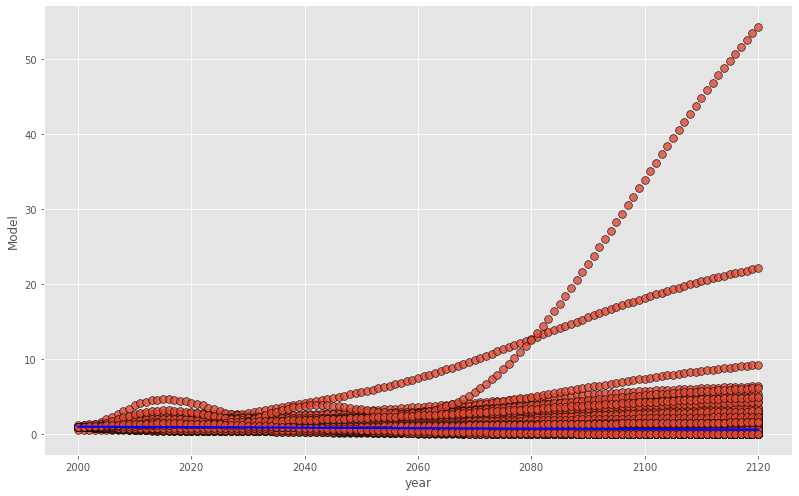

In [ ]:
gridobj = sns.lmplot(x="year", y="Model", data=grows_model,
                     height=7, aspect=1.6, robust=True,
                     line_kws={"color": "blue"},
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

In [ ]:
grows_model[grows_model['year'] == 2120].sort_values('Model', ascending=False).head()

,City,year,Model
29523,Гудермес,2120,54.250559
9558,Магас,2120,22.113208
9679,Назрань,2120,9.267617
483,Анапа,2120,6.423951
26619,Каспийск,2120,6.160886


То есть модель прогнозирует наибольший рост численности населения в городе Гудермес.


Выводы:
1. Наибольшей численностью населения обладает Москва.
2. Основной прирост от году к году составляет от 0 до 10%, приросты больше в основном в малом количестве.
3. Если брать основной прирост по модели, то наибольший при рост населения будет в городах Гудермес, Магас.